In [3]:
from flu_matrix_completion import *

In [4]:
'''
Prepare a source for predictions:
- Identify a 2 datasets with good transferability
- Choose source dataset
- Train and cross validate a tree for every virus in source dataset, choosing 5 best trees per virus
    - Feats and target both come from source
    - Select viable virus features from viruses which overlap both datasets!
- Now with a tree for every virus in Dataset 1
    - Pull required feature viruses from Dataset 2 and make a prediction with the tree
- Put the prediction thing above into a loop to see how well Dataset2 can be reconstructed
'''

'''
Predictions:

1.) Train comparison on datasets
2.) Go to OBJ.comparison_dict  holds trees trained on source data that target other dataset's viruses
3.) Go to OBJ.comparison_dict[COMPARISON] to access each target virus
4.) Go to OBJ.comparison_dict[COMPARISON][VIRUS] to access each target virus's:
    - regression model (IMPORTANT)
    - intraRMSE
    - crossRMSE
    - feature viruses (IMPORTANT)
    - predictions
'''
def predict_target(m_best_trees_trainer_lists, target_dataset, mean_impute=False):
    '''
    Assuming target_dataset contains data for each virus in virus_col_sel
    
    dtr: model
    virus_col_sel: features to use for prediction
    feature_t: virus to be predicted in target_dataset
    '''
    
    just_means = []
    predictions_to_be_meaned = []
    for l in m_best_trees_trainer_lists:
        dtr, _, _, virus_col_sel, feature_t, _, _ = l
        X = target_dataset[virus_col_sel]
        col_mean = (X).apply(lambda x: x.mean(), axis=1)
        centering_matrix =  np.outer(np.ones(X.shape[1]), col_mean).T
        X_m_centered = X - centering_matrix # Center data
        preds = dtr.predict(X_m_centered.to_numpy())
        just_means.append(col_mean) # For baseline comparison to mean imputation
        predictions_to_be_meaned.append(preds + col_mean) # Uncenter prediction
    predictions_to_be_meaned = np.array(predictions_to_be_meaned)
    if mean_impute: # DONT USE THIS UNLESS YOU ARE SEEKING TO ONLY DO MEAN IMPUTATION TO CHECK BASELINE
        return np.mean(just_means, axis=0)
    return np.mean(predictions_to_be_meaned, axis=0) # Returns a list of prediction corresponding to each antibody sera in target_dataset

def train_cross_dataset_model(source_table, target_table, n_feature = 7, f_sample=0.3, train_trees=50, best_trees=10):
    '''
    Returns a dict where "viable" viruses are keys and m_best_trees_trainer_lists are values
    '''
    source_table_feature_set = set(source_table.columns)
    target_table_feature_set = set(target_table.columns)
    intersection = list(source_table_feature_set.intersection(target_table_feature_set)) # Train trees on random samples from intersection
    
    m_best_trees_trainer_lists_per_target_virus = dict()
    for feature_t in list(source_table_feature_set):
        selected_viruses_list = np.random.choice(intersection, n_feature) # Might need to tweak this step to consider depth of data...
#         print(type(selected_viruses_list), selected_viruses_list)
        source_table_trees = m_best_trees_trainer(target_table = source_table,
                                                  source_tables = [source_table],
                                                  feature_t = feature_t,
                                                  selected_viruses_list= selected_viruses_list,
                                                  n_feature = n_feature,
                                                  f_sample=f_sample,
                                                  train_trees=train_trees,
                                                  best_trees=best_trees)
        m_best_trees_trainer_lists_per_target_virus[feature_t] = source_table_trees
    return m_best_trees_trainer_lists_per_target_virus, intersection # intersection will tell you which virus to assign to your predictions

def compute_predicted_df(m_best_trees_trainer_lists_per_target_virus, intersection, target_dataset, mean_impute=False):
    
    df = pd.DataFrame(np.nan, index=target_dataset.index, columns=target_dataset.columns)
    
    for key in m_best_trees_trainer_lists_per_target_virus:
#         for sera in target_dataset.index:
#             print()
        m_best_trees_trainer_lists = m_best_trees_trainer_lists_per_target_virus[key]
        df.loc[:, key] = predict_target(m_best_trees_trainer_lists, target_dataset, mean_impute=mean_impute)
        
    return df.dropna(axis=0, how='all')


In [5]:
# Load in antisera-virus data as pd.DataFrames
HI_df = pd.read_csv("data/fonville_2014.csv", index_col='sampleID')
antisera_df = pd.read_csv("data/fonville_2014_antisera_table.csv", index_col='sampleID')
## Add data to HI_data_tables object
flu_data_tables = HI_data_tables() # Create HI_data_tables object
flu_data_tables.add_HI_data(HI_df=HI_df,
                            antisera_df=antisera_df) # Add data from Tal's ad Rong's original paper
flu_data_tables.compute_virus_dates() # Call compute_virus_dates method to compute years of virus

# Load in antisera-virus data as pd.DataFrames
all_HI_df = pd.read_csv("data/fonville_hinojosa_ertesvag_data.csv", index_col='sampleID')
all_antisera_df = pd.read_csv("data/fonville_merged_hinojosa_antisera_table.csv", index_col='sampleID')
all_HI_data_tables  = HI_data_tables() # Create HI_data_tables object
all_HI_data_tables.add_HI_data(HI_df=all_HI_df,
                               antisera_df=all_antisera_df) # Add data from Tal's ad Rong's original paper
all_HI_data_tables.compute_virus_dates()

In [6]:
HI_df

BI/16190/68  BI/21793/72  BI/2271/76  \
sampleID                                                                   
Serum_A/WELLINGTON/25/93_TableS1            NaN          NaN         NaN   
Serum_A/WELLINGTON/96/93_TableS1            NaN          NaN         NaN   
Serum_A/VICTORIA/9/94_TableS1               NaN          NaN         NaN   
Serum_A/JOHANNESBURG/33/94_TableS1          NaN          NaN         NaN   
Serum_A/SHANDONG/9/93_TableS1               NaN          NaN         NaN   
...                                         ...          ...         ...   
SubjectA028_Post_TableS14               1.30103          NaN     1.60206   
SubjectA020_Post_TableS14               0.69897          NaN     1.90309   
SubjectB025_Post_TableS14               2.20412          NaN     0.69897   
SubjectB040_Post_TableS14               2.50515          NaN     2.20412   
SubjectB039_Post_TableS14               1.90309          NaN     0.69897   

                                    BI/1761/76  NL/233/82  NL/620/89  \
sampleID                                                               
Serum_A/WELLINGTON/25/93_TableS1           NaN        NaN        NaN   
Serum_A/WELLINGTON/96/93_TableS1           NaN        NaN        NaN   
Serum_A/VICTORIA/9/94_TableS1              NaN        NaN        NaN   
Serum_A/JOHANNESBURG/33/94_TableS1         NaN        NaN        NaN   
Serum_A/SHANDONG/9/93_TableS1              NaN        NaN        NaN   
...                                        ...        ...        ...   
SubjectA028_Post_TableS14              0.69897    2.20412    1.90309   
SubjectA020_Post_TableS14              1.00000    2.20412    1.90309   
SubjectB025_Post_TableS14              0.69897    0.69897    0.69897   
SubjectB040_Post_TableS14              1.90309    2.20412    2.20412   
SubjectB039_Post_TableS14              0.69897    0.69897    1.00000   

                                    NL/823/92  A/BEIJING/32/92  \
sampleID                                                         
Serum_A/WELLINGTON/25/93_TableS1          NaN          2.80618   
Serum_A/WELLINGTON/96/93_TableS1          NaN          2.20412   
Serum_A/VICTORIA/9/94_TableS1             NaN          2.20412   
Serum_A/JOHANNESBURG/33/94_TableS1        NaN          1.60206   
Serum_A/SHANDONG/9/93_TableS1             NaN          2.50515   
...                                       ...              ...   
SubjectA028_Post_TableS14             1.90309              NaN   
SubjectA020_Post_TableS14             1.90309              NaN   
SubjectB025_Post_TableS14             1.60206              NaN   
SubjectB040_Post_TableS14             1.90309              NaN   
SubjectB039_Post_TableS14             1.00000              NaN   

                                    A/WELLINGTON/25/93  A/WELLINGTON/96/93  \
sampleID                                                                     
Serum_A/WELLINGTON/25/93_TableS1               2.80618             1.90309   
Serum_A/WELLINGTON/96/93_TableS1               3.40824             2.50515   
Serum_A/VICTORIA/9/94_TableS1                  3.40824             2.50515   
Serum_A/JOHANNESBURG/33/94_TableS1             3.10721             2.80618   
Serum_A/SHANDONG/9/93_TableS1                  2.80618             2.20412   
...                                                ...                 ...   
SubjectA028_Post_TableS14                          NaN             1.60206   
SubjectA020_Post_TableS14                          NaN             1.00000   
SubjectB025_Post_TableS14                          NaN             1.30103   
SubjectB040_Post_TableS14                          NaN             1.60206   
SubjectB039_Post_TableS14                          NaN             1.60206   

                                    ...  HN206/2009  HN201/2009  HN196/2009  \
sampleID                            ...                                       
Serum_A/WELLINGTON/25/93_TableS1    ...         NaN         NaN         NaN   

## Load Fonville 2014 Data

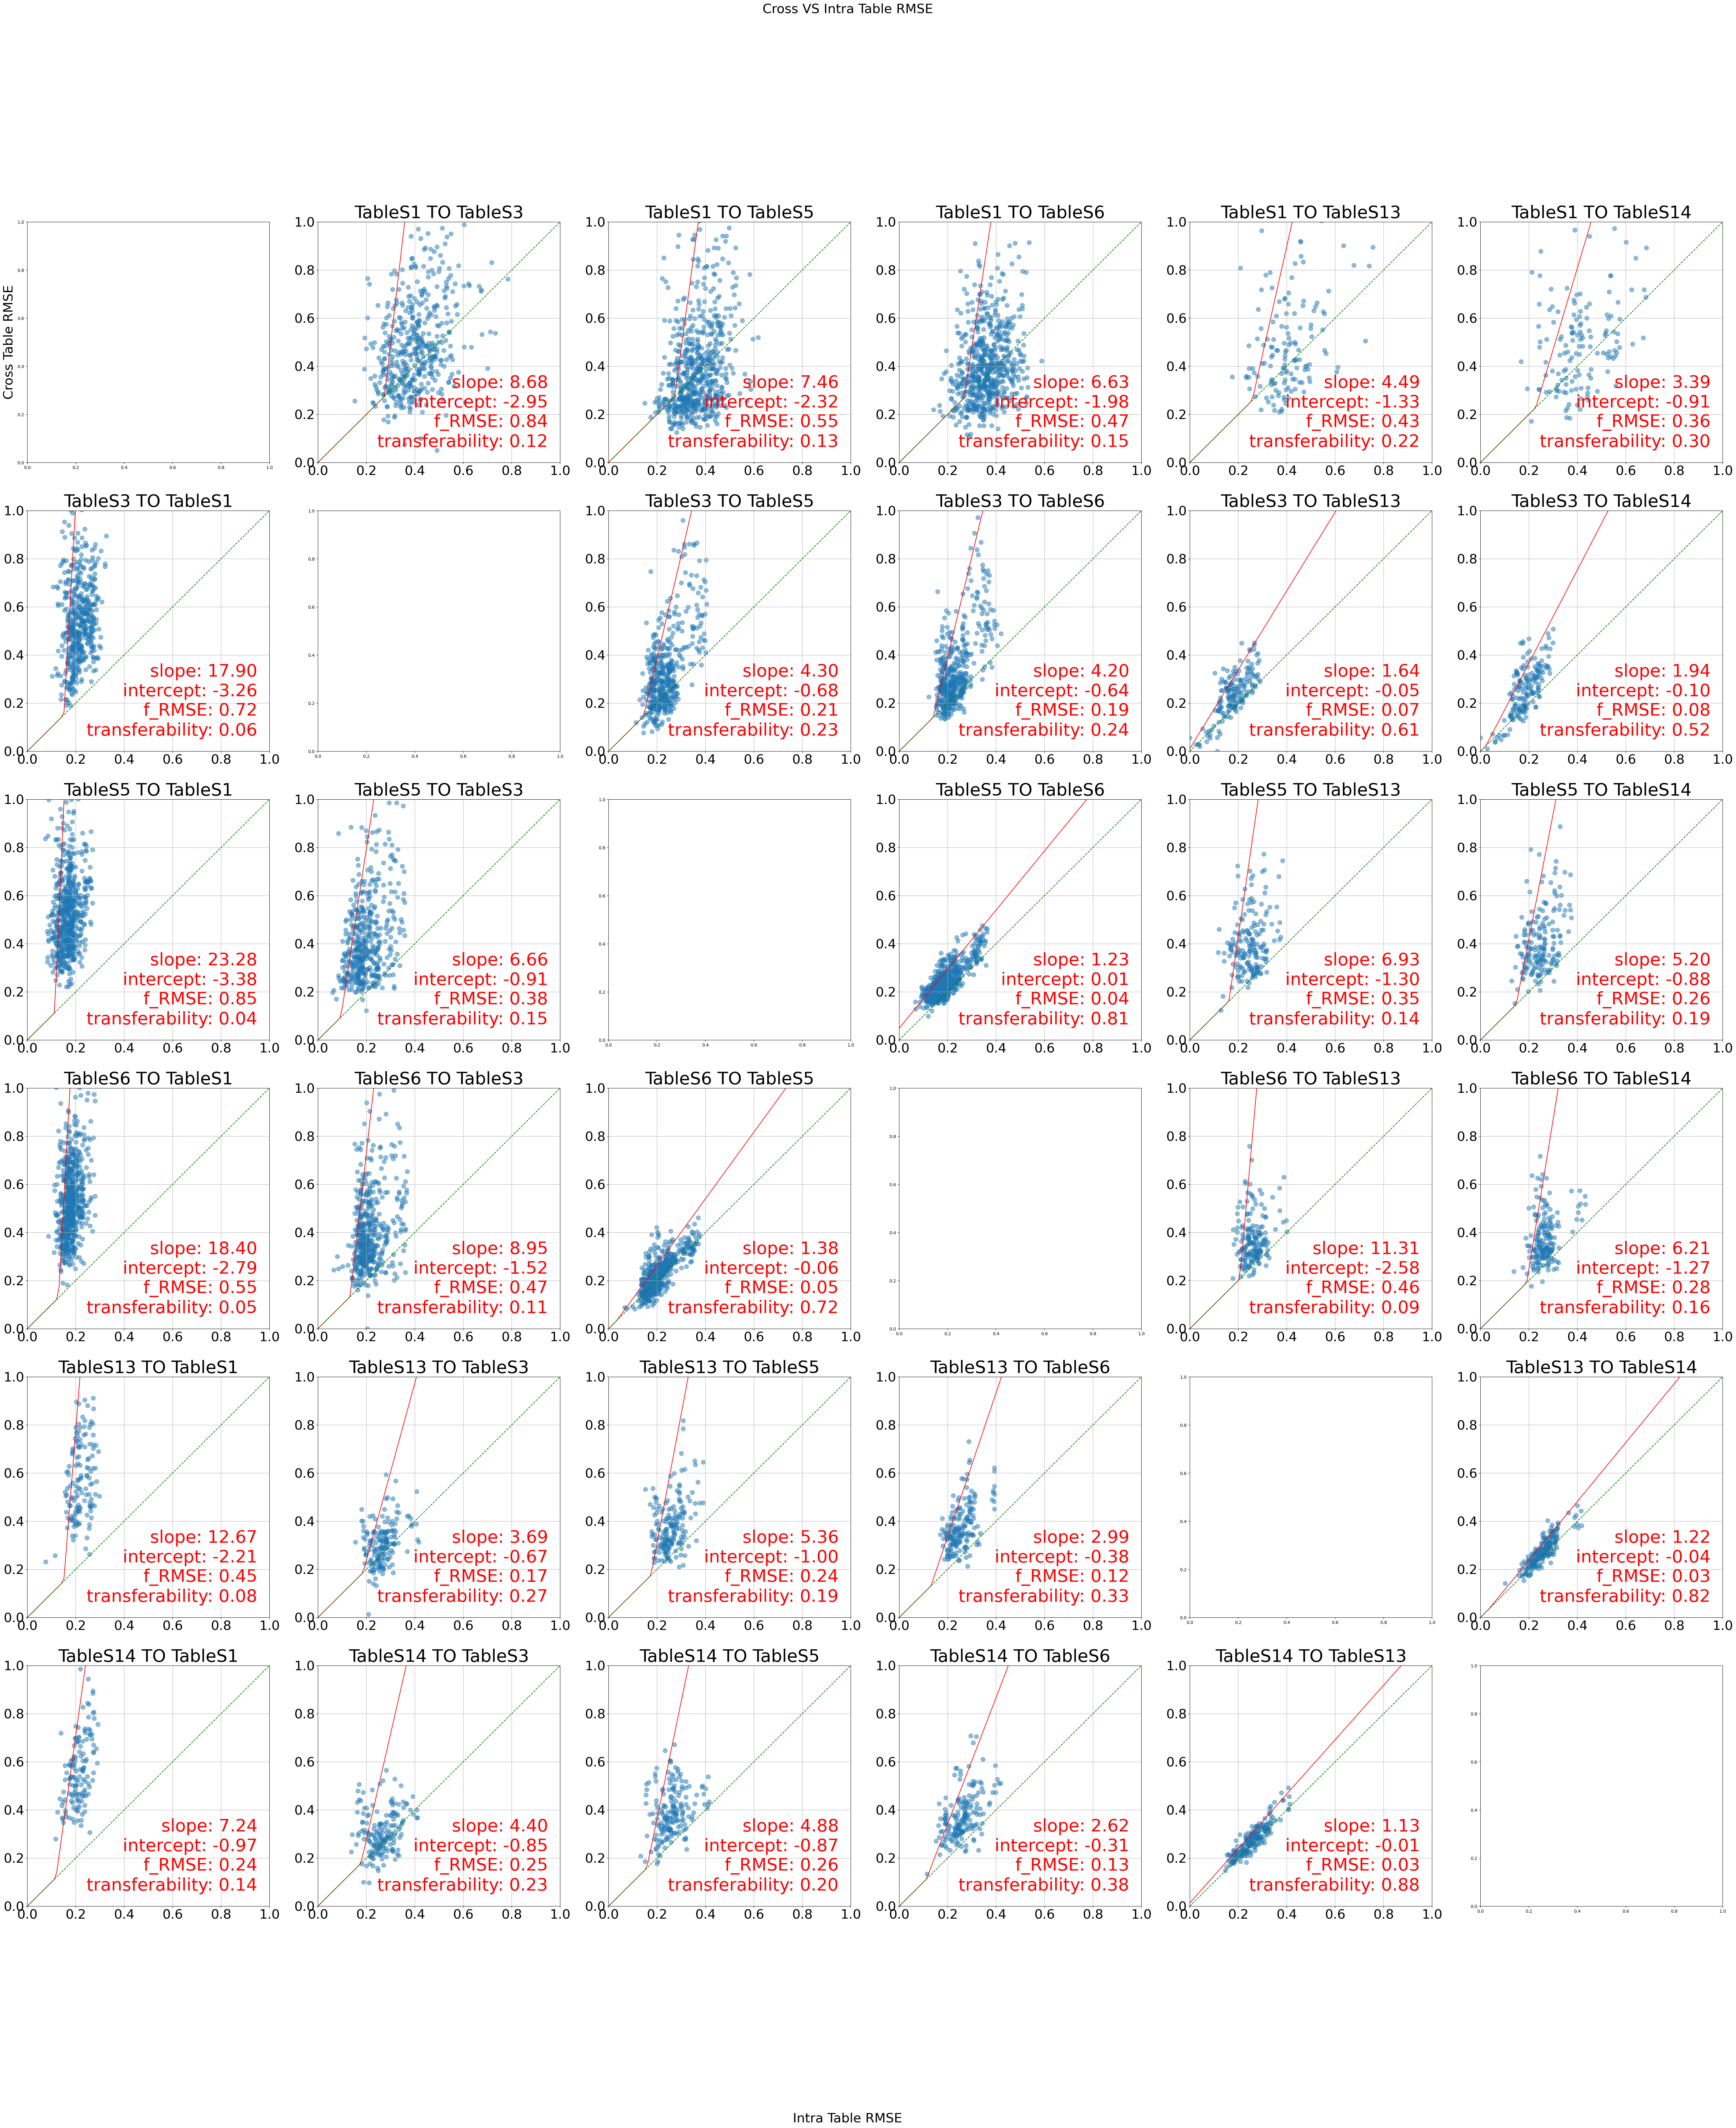

In [23]:
# Load in antisera-virus data as pd.DataFrames
fonville_2014_HI_df = pd.read_csv("data/fonville_2014.csv", index_col='sampleID')
fonville_2014_antisera_df = pd.read_csv("data/fonville_2014_antisera_table.csv", index_col='sampleID')
fonville_2014_HI_data_tables  = HI_data_tables() # Create HI_data_tables object
fonville_2014_HI_data_tables.add_HI_data(HI_df=fonville_2014_HI_df,
                               antisera_df=fonville_2014_antisera_df) # Add data from Tal's ad Rong's original paper
fonville_2014_HI_data_tables.compute_virus_dates()

np.random.seed(10)
train_trees=50
best_trees=10
n_features=5
f_sample = 0.7
fonville_2014_comparisons_obj = transferability_comparisons(HI_data_tables=fonville_2014_HI_data_tables)
model_name = f'fonville_2014_w_ODRs__traintrees{train_trees}_besttrees{best_trees}_regular_features{n_features}'
# fonville_2014_comparisons_obj.load_data(path=f"models/{model_name}.pkl")
fonville_2014_comparisons_obj.train_comparison_trees(train_trees=train_trees, best_trees=best_trees, n_features=n_features, f_sample=f_sample)
fonville_2014_comparisons_obj.compute_comparison_virus_ODR_df_dict()
fonville_2014_comparisons_obj.plot_comparisons_with_ODRs(save_to=f'figs/{model_name}.png', figsize=(70,70), s=100,  alpha=0.5)
fonville_2014_comparisons_obj.save_data(save_to=f"models/{model_name}.pkl")

In [7]:
model_name

'fonville_2014_w_ODRs__traintrees50_besttrees10_regular_features5'

# Predictions

## Fonville 2014 S14 80/20 split results

In [17]:
import random
import os
import pickle
# Load in data
np.random.seed(10)
split_HI_df = pd.read_csv("data/fonville_hinojosa_ertesvag_data.csv", index_col='sampleID')
split_antisera_df = pd.read_csv("data/fonville_merged_hinojosa_antisera_table.csv", index_col='sampleID')
split_HI_data_tables  = HI_data_tables() # Create HI_data_tables object
split_HI_data_tables.add_HI_data(HI_df=split_HI_df,
                               antisera_df=split_antisera_df) # Add data from Tal's ad Rong's original paper
split_HI_data_tables.compute_virus_dates()
# Get 80/20 split indices
dataset = split_HI_data_tables.select_HI_data_by_group(["TableS6"]).dropna(axis=1, how="all").dropna(axis=0, how="any")
index_list = list(dataset.index)
random.shuffle(index_list)
split_point = int(len(index_list) * 0.8)
train_indices = index_list[:split_point]
test_indices = index_list[split_point:]
# Mark samples for 80/20 split
split_HI_data_tables.antisera_table.loc[train_indices, 'groupID'] = 'Train'
split_HI_data_tables.antisera_table.loc[test_indices, 'groupID'] = 'Test'

In [1]:
source_table_split

NameError: name 'source_table_split' is not defined

In [2]:
np.random.seed(10)

train_trees = 200
best_trees = 4
n_features = 50
f_sample = 0.8
model_name = f'train_test_split_model_fonville2014_traintrees{train_trees}_besttrees{best_trees}_nfeatures{n_features}_fsample{f_sample}_ensemblelist'

source_table_split = split_HI_data_tables.select_HI_data_by_group(group=['Train']).dropna(axis=1, how='all').dropna(axis=0, how='any')
target_table_split = split_HI_data_tables.select_HI_data_by_group(group=['Test']).dropna(axis=1, how='all').dropna(axis=0, how='any')

if f'{model_name}.pkl'in os.listdir("models/"):
    pickle.load()
else:
    m_best_trees_trainer_lists_per_target_virus_split, intersection_split = train_cross_dataset_model(source_table_split, target_table_split, n_feature = n_features, f_sample=f_sample, train_trees=train_trees, best_trees=best_trees)

# Save Model
my_list = [m_best_trees_trainer_lists_per_target_virus_split, intersection_split]
file_path = f'{model_name}.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(my_list, file)

# Compute Predictions
target_table_split_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus_split, intersection_split, target_table_split)
target_table_split_mean_baseline_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus_split, intersection_split, target_table_split, mean_impute=True)

RMSE = np.sqrt(np.mean((target_table_split_predictions - target_table_split)**2))
baselineRMSE = np.sqrt(np.mean((target_table_split_mean_baseline_predictions - target_table_split)**2))

print("RMSE:",RMSE)
print("Mean Imputed RMSE:",baselineRMSE)

NameError: name 'np' is not defined

In [21]:
model_name

'fonville_2014_w_ODRs__traintrees50_besttrees10_regular_features5'

In [19]:
my_list = [m_best_trees_trainer_lists_per_target_virus_split, intersection_split]
file_path = f'models/{model_name}.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(my_list, file)

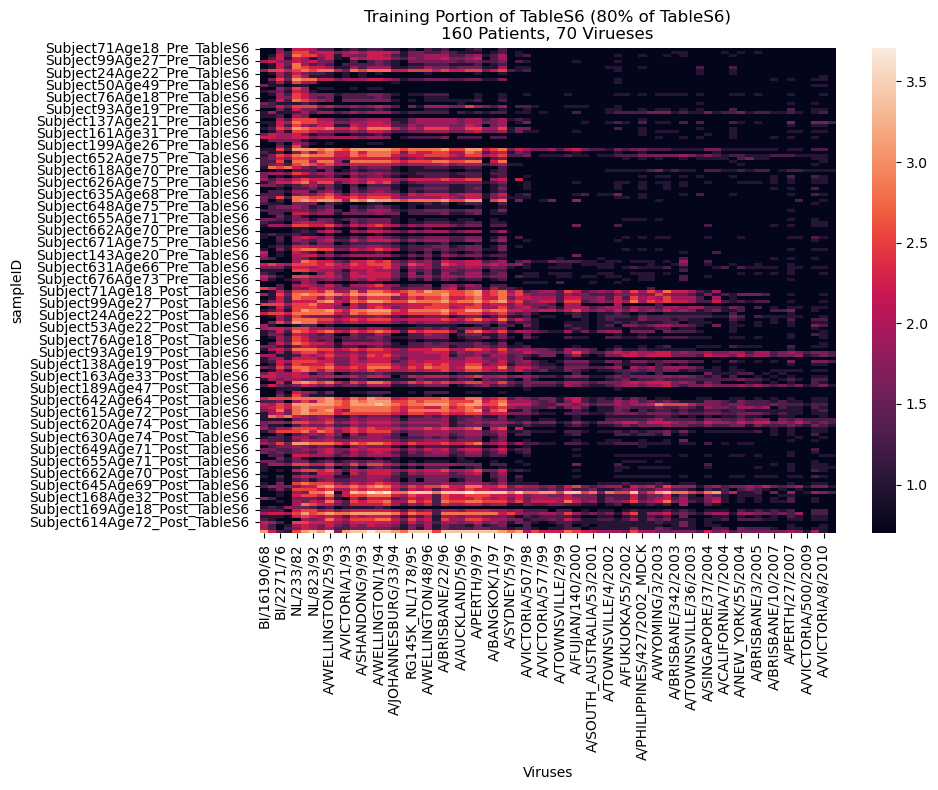

In [13]:
'''
Training data plot
'''
plt.figure(figsize=(10,8))
p, v = source_table_split.shape
plt.title(f"Training Portion of TableS6 (80% of TableS6)\n{p} Patients, {v} Virueses")
sns.heatmap(source_table_split)
# Adjust layout to prevent overlap
plt.xlabel("Viruses")
plt.tight_layout()

# Show the plot
plt.show()

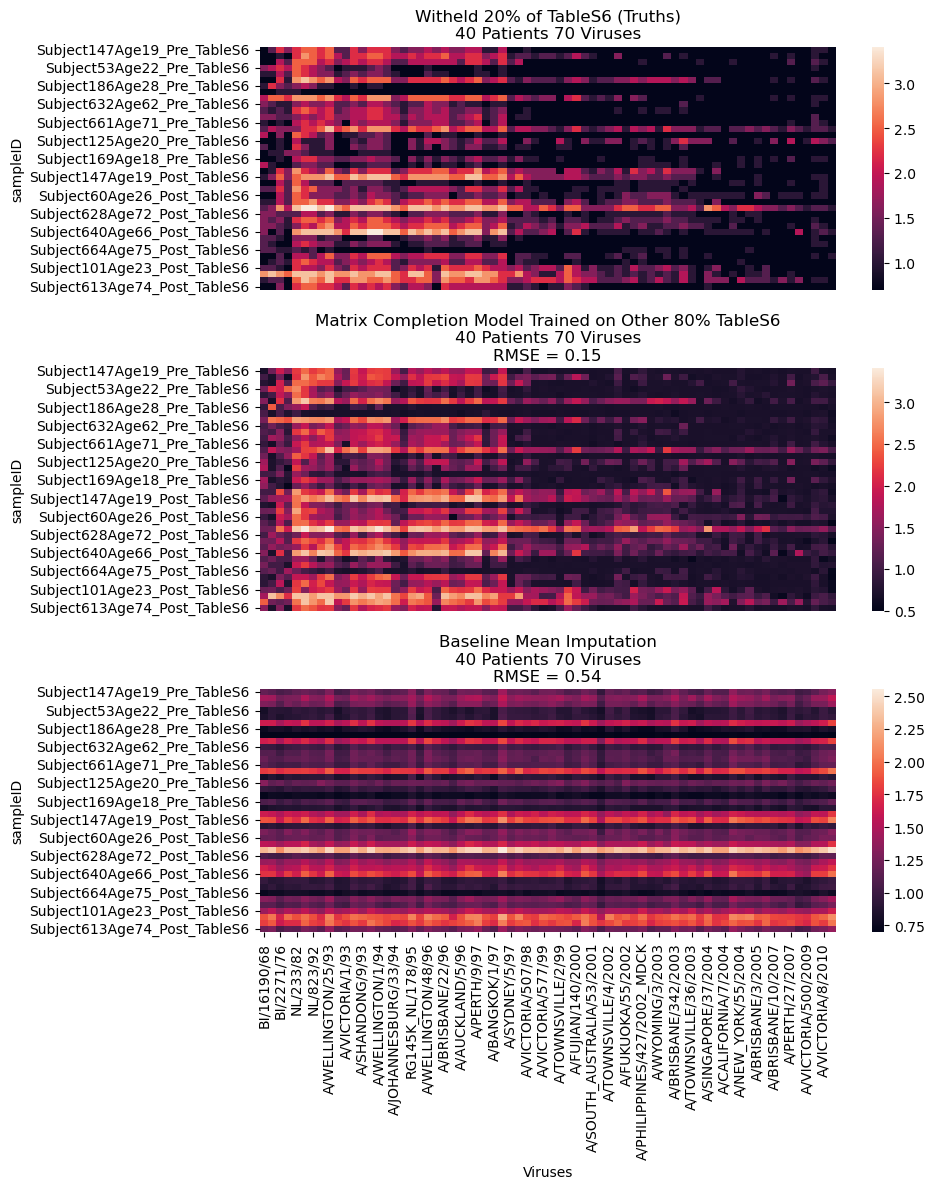

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(target_table_split, ax=axes[0]).set(xticks=[], xlabel='')
# Plot the second heatmap
sns.heatmap(target_table_split_predictions, ax=axes[1]).set(xticks=[], xlabel='')
# Plot the third heatmap
sns.heatmap(target_table_split_mean_baseline_predictions, ax=axes[2])

# Set titles for subplots
# axes[0].set_title("TableS6 (Training Data)")
p, v = target_table_split.shape
axes[0].set_title(f'Witheld 20% of TableS6 (Truths)\n{p} Patients {v} Viruses')
axes[1].set_title(f'Matrix Completion Model Trained on Other 80% TableS6\n{p} Patients {v} Viruses\nRMSE = {RMSE:.2f}')
axes[2].set_title(f'Baseline Mean Imputation\n{p} Patients {v} Viruses\nRMSE = {baselineRMSE:.2f}')
axes[2].set_xlabel("Viruses")
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Fonville 2014 Completing Table S13 with S14: Completion between highly transferable datasets
To Continue!Rare chance to actually compute RMSE for prediction on whole matrix

0.2635602818956513


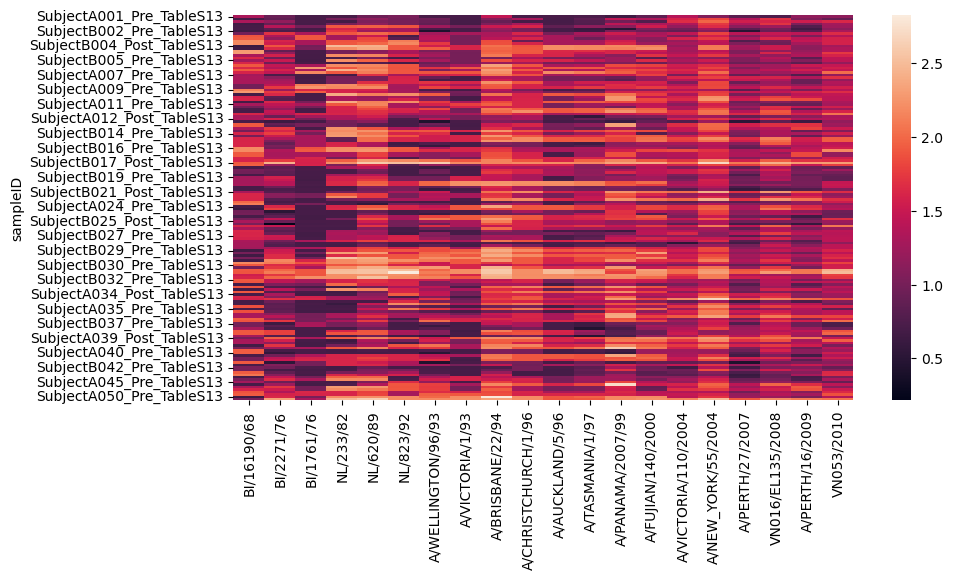

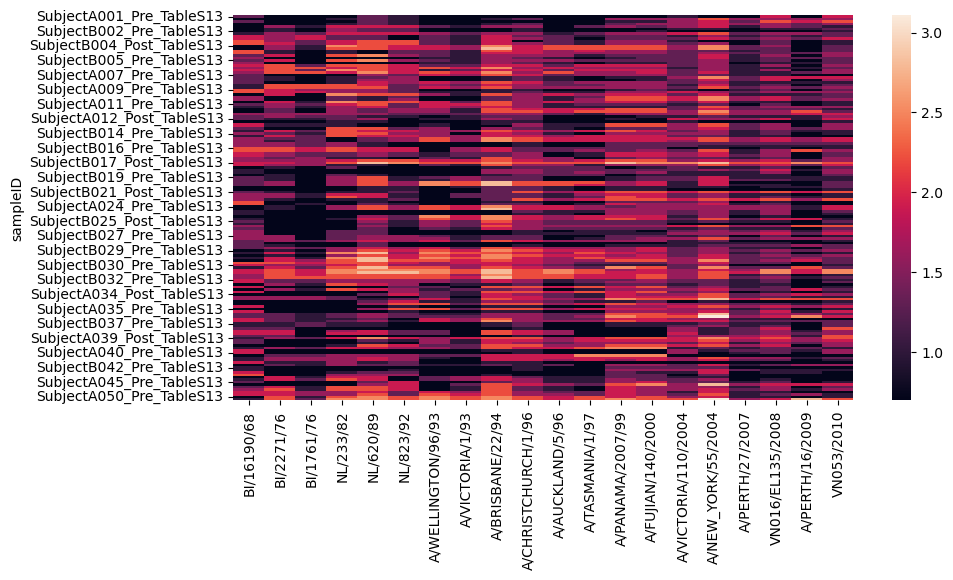

In [7]:
'''
Improves performance:
    - Increasing n_feature
    - Increasing f_sample
    - Increasing train_trees and decreasing best_trees 
Worsens performance: 
    - Increasing best_trees alone

'''
np.random.seed(10)

train_trees = 100
best_trees = 10
n_features = 10
f_sample = 0.8
model_name = f'fonville2014_S14toS13_model_traintrees{train_trees}_besttrees{best_trees}_nfeatures{n_features}_fsample{f_sample}_ensemblelist'

source_table_1 = all_HI_data_tables.select_HI_data_by_group(group=['TableS14']).dropna(axis=1, how='all').dropna(axis=0, how='any')
target_table_1 = all_HI_data_tables.select_HI_data_by_group(group=['TableS13']).dropna(axis=1, how='all').dropna(axis=0, how='any')

m_best_trees_trainer_lists_per_target_virus_1, intersection_1 = train_cross_dataset_model(source_table_1, target_table_1, n_feature = n_feature, f_sample=f_sample, train_trees=train_trees, best_trees=best_trees)
target_table_1_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus_1, intersection_1, target_table_1)

RMSE_1 = np.sqrt(np.mean((target_table_1_predictions - target_table_1)**2))
print(RMSE_1)

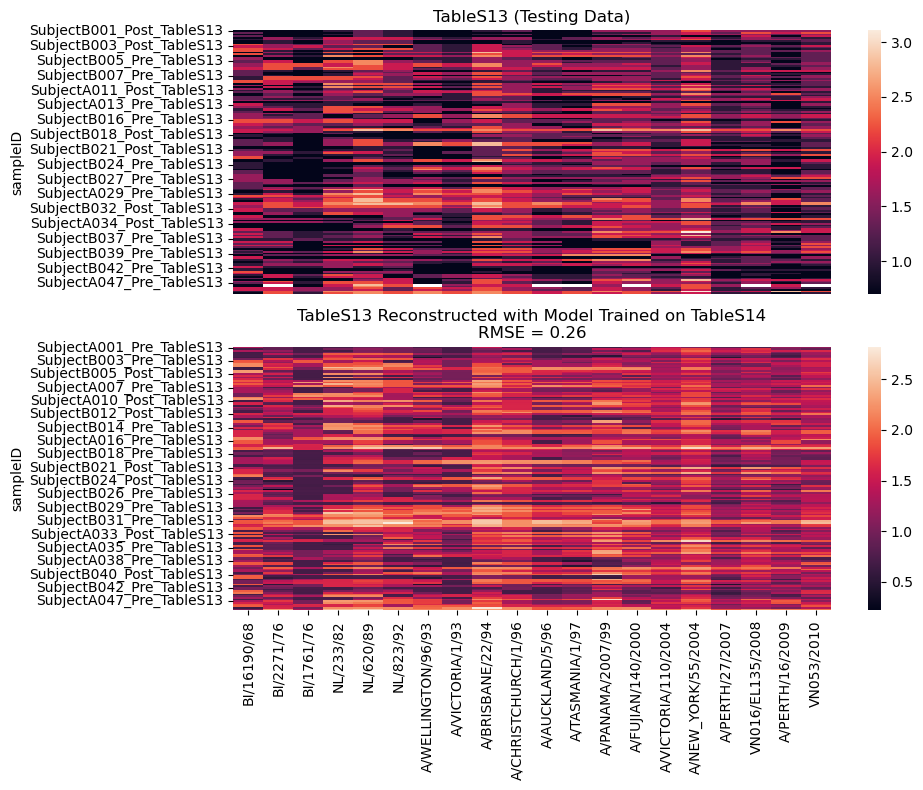

In [47]:

S14_data = all_HI_data_tables.select_HI_data_by_group(group=['TableS14']).dropna(axis=1, how="all")
age_indices_S14_data = np.argsort([i.split('_')[0][-3:] for i in S14_data.index])
S14_data = S14_data.iloc[age_indices_S14_data]

S13_data = all_HI_data_tables.select_HI_data_by_group(group=['TableS13']).dropna(axis=1, how="all")
age_indices_S13_data = np.argsort([i.split('_')[0][-3:] for i in S13_data.index])
S13_data = S13_data.iloc[age_indices_S13_data]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 1 row, 2 columns

# Plot the first heatmap
# sns.heatmap(S14_data, ax=axes[0]).set(xticks=[], xlabel='')
# Plot the second heatmap
sns.heatmap(S13_data, ax=axes[0]).set(xticks=[], xlabel='')
# Plot the third heatmap
age_indices_1 = np.argsort([i.split('_')[0][-3:] for i in target_table_1_predictions.index])
sns.heatmap(target_table_1_predictions.iloc[age_indices_1], ax=axes[1])

RMSE = np.sqrt(np.mean((target_table_1_predictions.iloc[age_indices_1] - S13_data)**2))


# Set titles for subplots
# axes[0].set_title("TableS14 (Training Data)")
axes[0].set_title('TableS13 (Testing Data)')
axes[1].set_title(f'TableS13 Reconstructed with Model Trained on TableS14\nRMSE = {RMSE:.2f}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [317]:
len(intersection_2)

14

## Fonville 2014 to 2016 Ferrets

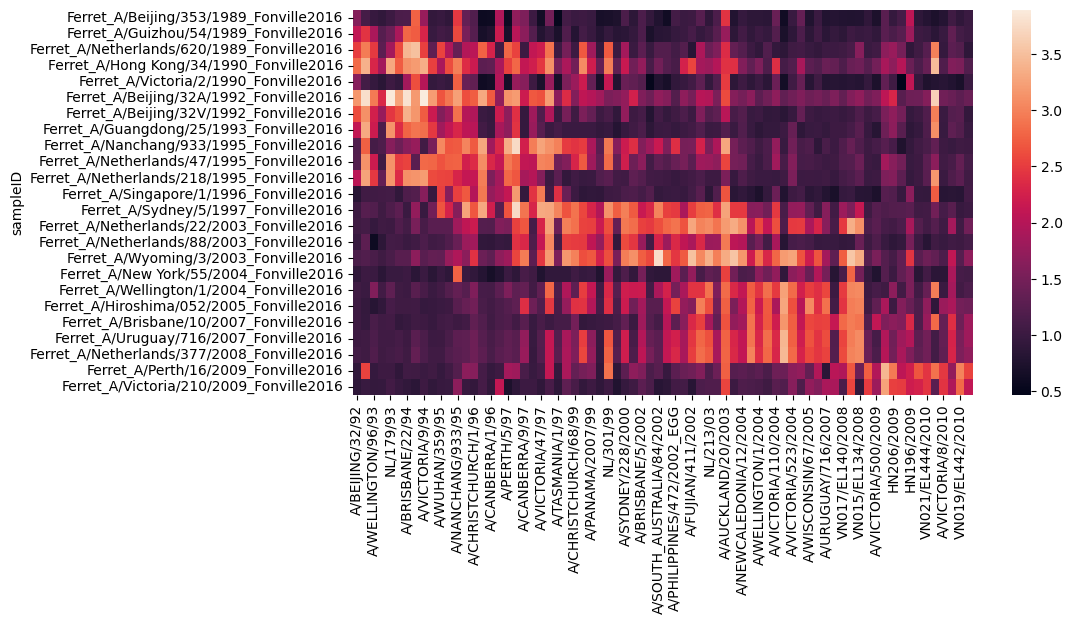

<Axes: ylabel='sampleID'>

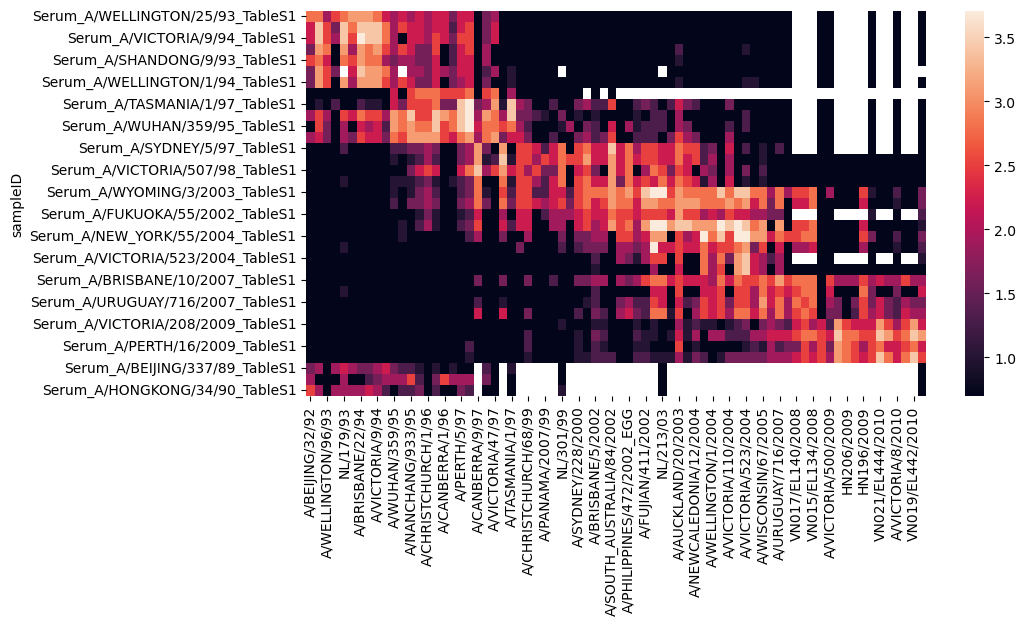

In [286]:
source_table_2 = all_HI_data_tables.select_HI_data_by_group(group=['TableS1']).dropna(axis=1, how='all')
target_table_2 = all_HI_data_tables.select_HI_data_by_group(group=['fon_ferrets']).dropna(axis=1, how='all')
m_best_trees_trainer_lists_per_target_virus_2, intersection_2 = train_cross_dataset_model(source_table_2, target_table_2, n_feature = 20, f_sample=0.8, train_trees=200, best_trees=10)
# print(len(intersection_2))
target_table_2_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus_2, intersection_2, target_table_2)
target_table_2_mean_baseline_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus_2, intersection_2, target_table_2, mean_impute=True)

# RMSE = np.sqrt(np.mean((target_table_2_predictions[source_table_2.columns] - source_table_2)**2))
# print(RMSE)
plt.figure(figsize=(10,5))
sns.heatmap(target_table_2_predictions[source_table_2.columns])
plt.show()
plt.figure(figsize=(10,5))
sns.heatmap(source_table_2)

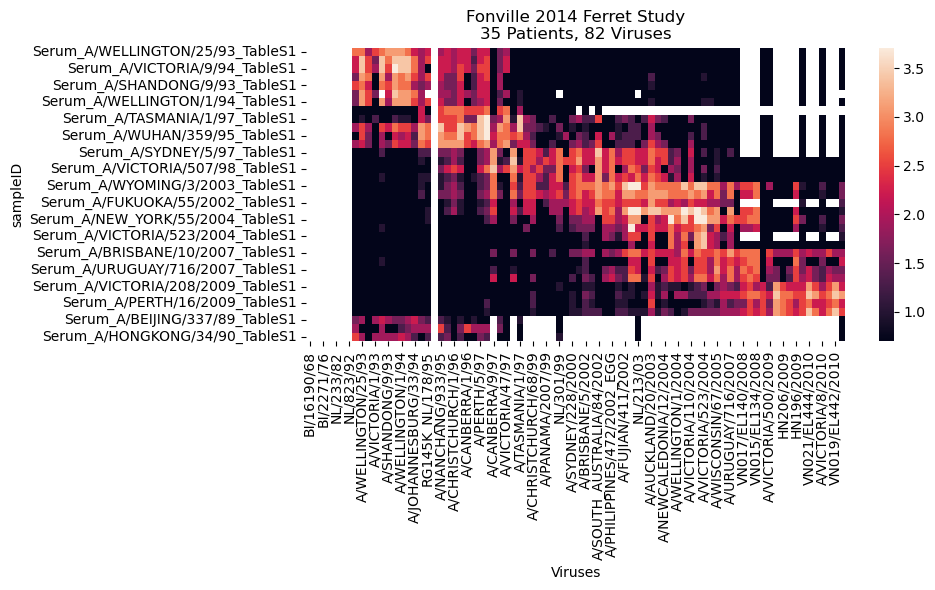

In [319]:
'''
Training data plot
'''
plt.figure(figsize=(10,6))
p, v = all_HI_data_tables.select_HI_data_by_group(group=['TableS1']).shape
plt.title(f"Fonville 2014 Ferret Study\n{p} Patients, {v} Viruses")
sns.heatmap(all_HI_data_tables.select_HI_data_by_group(group=['TableS1']))
# Adjust layout to prevent overlap
plt.xlabel("Viruses")
plt.tight_layout()

# Show the plot
plt.show()


In [324]:
from sklearn import tree

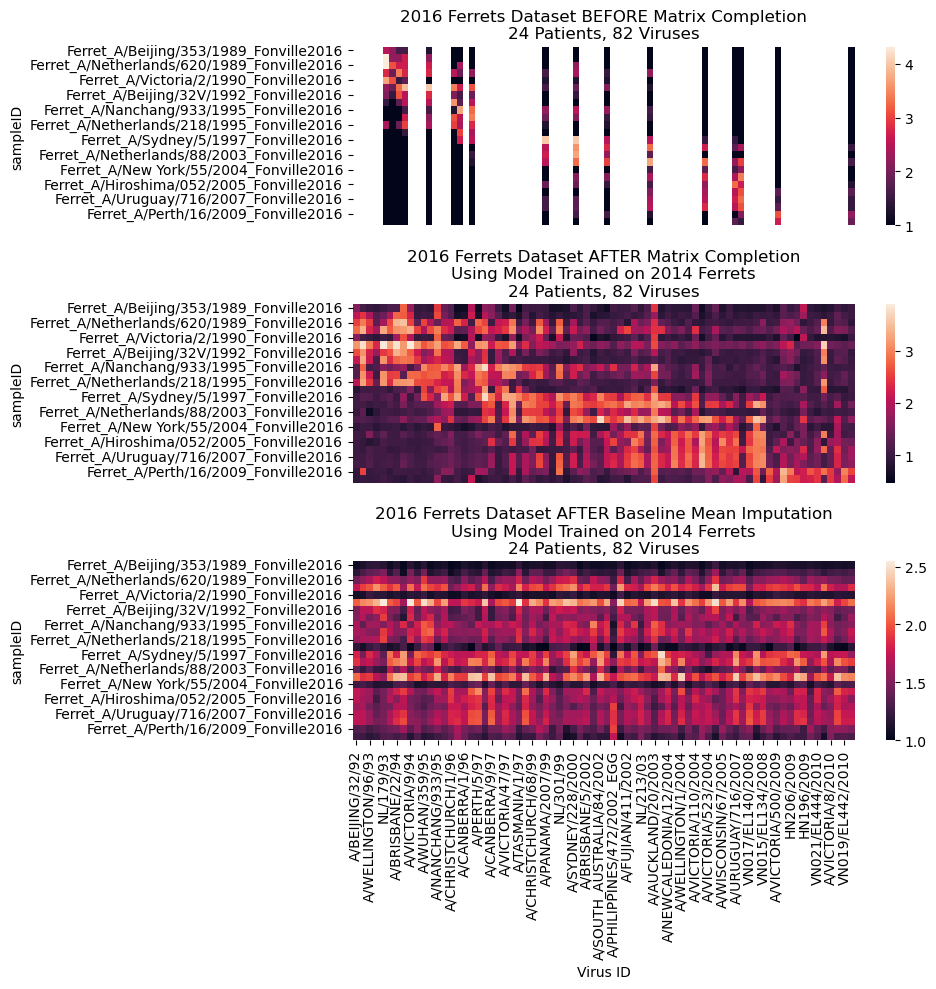

In [323]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))  # 1 row, 2 columns

focus_table = all_HI_data_tables.select_HI_data_by_group(group=['TableS1', 'fon_ferrets'])
fon_ferret_indices = all_HI_data_tables.antisera_table.index[all_HI_data_tables.antisera_table.groupID.to_numpy()=='fon_ferrets']
fon_ferret_table = focus_table.loc[fon_ferret_indices]

#anylot the first heatmap
sns.heatmap(fon_ferret_table, ax=axes[0]).set(xticks=[], xlabel='')
# Plot the second heatmap
sns.heatmap(target_table_2_predictions[source_table_2.columns], ax=axes[1]).set(xticks=[], xlabel='')
# Plot the third heatmap
sns.heatmap(target_table_2_mean_baseline_predictions[source_table_2.columns], ax=axes[2])

# Set titles for subplots
p, v = fon_ferret_table.shape
axes[0].set_title(f"2016 Ferrets Dataset BEFORE Matrix Completion\n{p} Patients, {v} Viruses")
axes[1].set_title(f'2016 Ferrets Dataset AFTER Matrix Completion\nUsing Model Trained on 2014 Ferrets\n{p} Patients, {v} Viruses')
axes[2].set_title(f'2016 Ferrets Dataset AFTER Baseline Mean Imputation\nUsing Model Trained on 2014 Ferrets\n{p} Patients, {v} Viruses')
axes[2].set_xlabel("Virus ID")
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [329]:
clf = m_best_trees_trainer_lists_per_target_virus_2['HN201/2009'][0][0]

In [330]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_17 <= 0.34
|   |--- feature_16 <= 0.01
|   |   |--- value: [0.01]
|   |--- feature_16 >  0.01
|   |   |--- feature_17 <= -1.07
|   |   |   |--- value: [-1.20]
|   |   |--- feature_17 >  -1.07
|   |   |   |--- value: [-0.85]
|--- feature_17 >  0.34
|   |--- value: [1.29]



In [331]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

NameError: name 'iris' is not defined

<Figure size 2500x2000 with 0 Axes>

## Fonville 2014 Ferret Data for Completing Fonville 2016 Children Data

<Axes: ylabel='sampleID'>

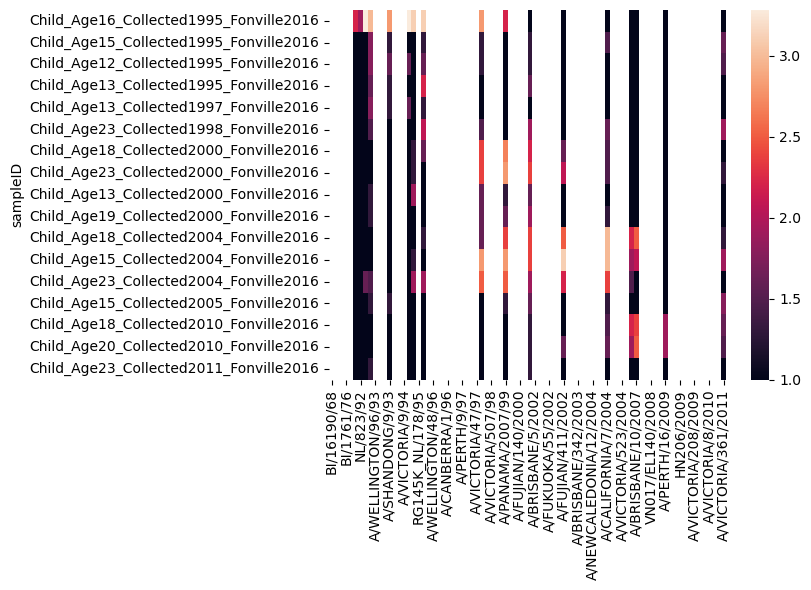

In [124]:
years = [int(i[i.index("Collected")+len('Collected') : i.index("Collected")+len('Collected')+4]) for i in all_HI_data_tables.select_HI_data_by_group(group=['fon_children']).index]
argsorted_ages = np.argsort(years)
sns.heatmap(all_HI_data_tables.select_HI_data_by_group(group=['fon_children']).iloc[argsorted_ages])

14


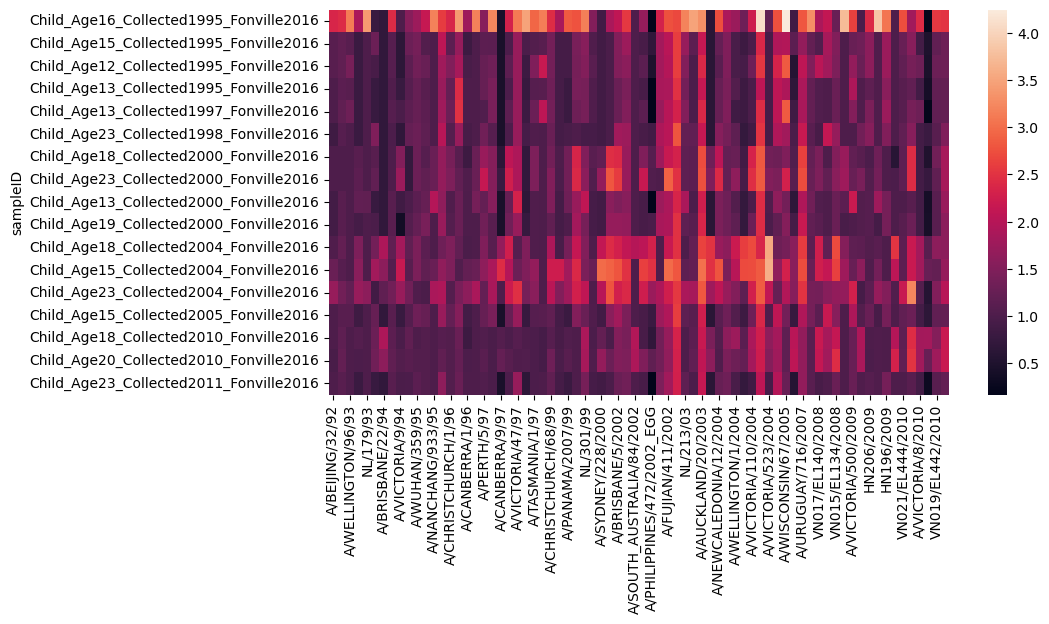

<Axes: ylabel='sampleID'>

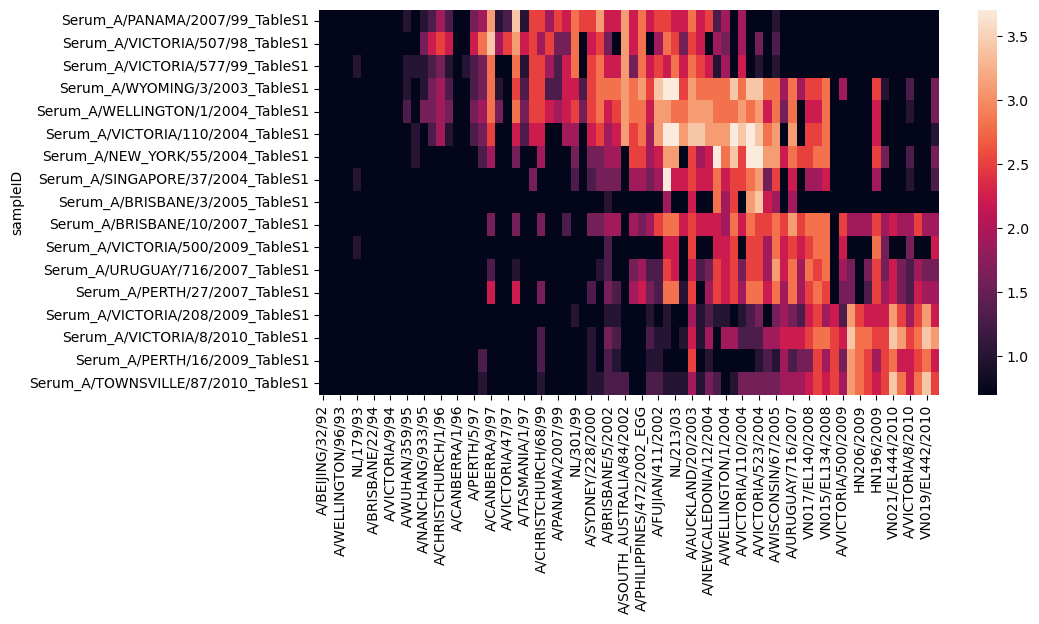

In [274]:
source_table = all_HI_data_tables.select_HI_data_by_group(group=['TableS1']).dropna(axis=1, how='all').dropna(axis=0, how='any')
target_table = all_HI_data_tables.select_HI_data_by_group(group=['fon_children']).dropna(axis=1, how='all').dropna(axis=0, how='any')
m_best_trees_trainer_lists_per_target_virus, intersection = train_cross_dataset_model(source_table, target_table, n_feature = 3, f_sample=0.8, train_trees=100, best_trees=10)
print(len(intersection))
target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus, intersection, target_table)

# RMSE = np.sqrt(np.mean((target_table_predictions[source_table.columns] - source_table)**2))
# print(RMSE)
plt.figure(figsize=(10,5))

years = [int(i[i.index("Collected")+len('Collected') : i.index("Collected")+len('Collected')+4]) for i in target_table_predictions[source_table.columns].index]
argsorted_ages = np.argsort(years)

sns.heatmap(target_table_predictions[source_table.columns].iloc[argsorted_ages])
plt.show()
plt.figure(figsize=(10,5))
sns.heatmap(source_table)

## Completing Fonvile 2014 TableS3 with Itself

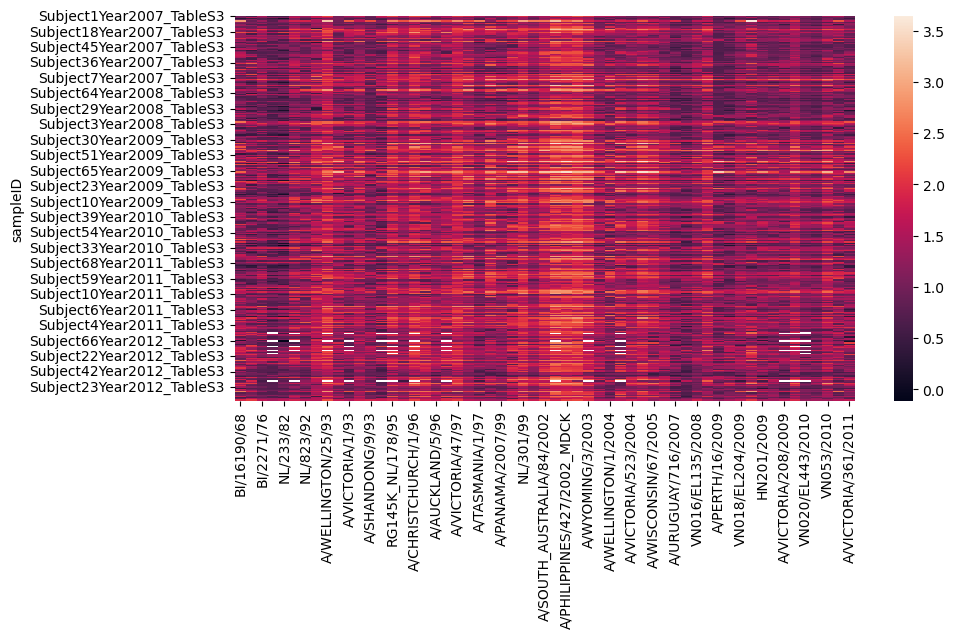

<Axes: ylabel='sampleID'>

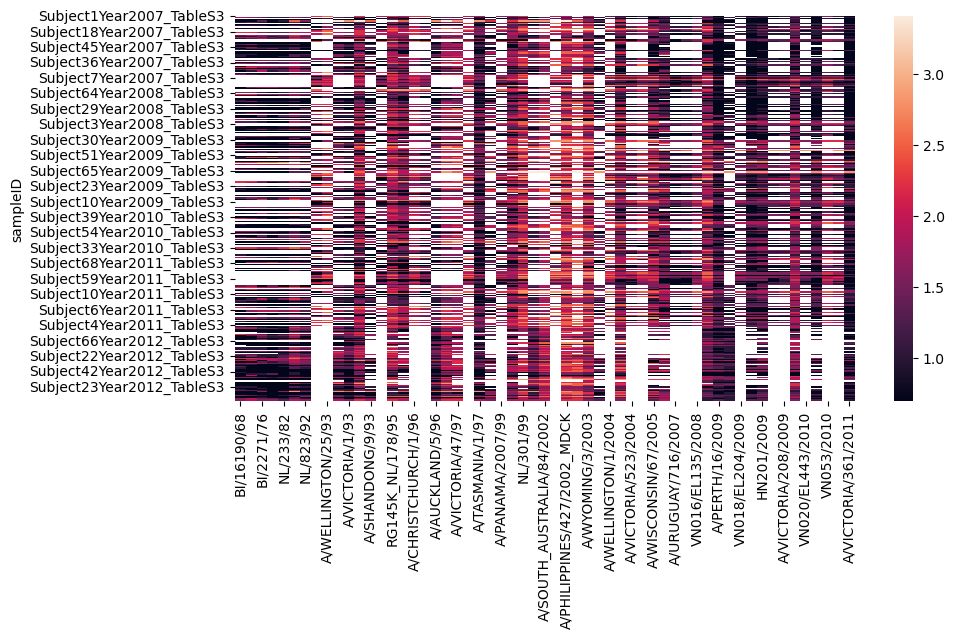

In [135]:
source_table_3 = all_HI_data_tables.select_HI_data_by_group(group=['TableS3']).dropna(axis=1, how='all')
target_table_3 = all_HI_data_tables.select_HI_data_by_group(group=['TableS3']).dropna(axis=1, how='all')
m_best_trees_trainer_lists_per_target_virus_3, intersection_3 = train_cross_dataset_model(source_table_3, target_table_3, n_feature = 8, f_sample=0.8, train_trees=200, best_trees=10)
# print(len(intersection_3))
target_table_3_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus_3, intersection_3, target_table_3)

# RMSE = np.sqrt(np.mean((target_table_3_predictions[source_table_3.columns] - source_table_3)**2))
# print(RMSE)
years = [int(i[i.index("Year")+4 : i.index("Year")+8]) for i in target_table_3_predictions[source_table_3.columns].index]
argsorted_ages = np.argsort(years)
plt.figure(figsize=(10,5))
sns.heatmap(target_table_3_predictions[source_table_3.columns].iloc[argsorted_ages])
plt.show()
plt.figure(figsize=(10,5))
sns.heatmap(source_table_3.iloc[argsorted_ages])

In [ ]:
'''
- Upload code
- Send Tal the fig of S1 with all data (include ertesvag too, no pre and post)

Use one of the two sera groups that Tal sends over (broken up S3)
- They were broken up into 2 groups to make data complete

Do S3 -> S5, 6, 13, 14 comparisons (Or reverse) and see range over n_features to see
if there is a sweet spot or if increasing them just makes everything better (RMSE)
- n_features (figure out a way to grid search this cuz number of intersecting/viable features will vary a lot)
- f_sample
- m_best trees
    - Also do train_trees in speial grid (IMPORTANT/non trivial setting)
- Find AVG RMSEs so i can see sweet spots in grid search
- Get an example which is hard to predict and see if parameter optimization fixes it
- When can a bad prediction become better when using more hyperparameters.
- Grow each forest with 200 trees
- Try dry run with small subset first

Also think ab S3.1/3.2 or S5/6 -> Other tables (S13/14).
- Average RMSE over whole dataset is a usable metric
- Pretty much just find some untransferable/bad predicting datasets with a good number of overlapping features

- Try diff models

Try a grid search (low priority)
- n_features
'''